In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten, SpatialDropout2D, SpatialDropout1D, AlphaDropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use("ggplot")


In [2]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions (Of the MNIST images)
img_rows, img_cols = 28, 28

In [12]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [13]:
accepted = [0, 1]
idx = [i for i, ele in enumerate(y_train) if ele in accepted]
x_train = x_train[idx]
y_train = y_train[idx]

In [14]:
x_train_re = x_train.reshape((x_train.shape[0], -1)) #flattens the list

In [15]:
x_train_re.shape

(12665, 784)

In [16]:
PCA_model = PCA(2)

In [17]:
fitted_PCA = PCA_model.fit(x_train_re).transform(x_train_re)

x = np.array([x[0] for x in fitted_PCA])
y = np.array([x[1] for x in fitted_PCA])

In [41]:
x = x[:100]
y = y[:100]
y_train = y_train[:100]

In [42]:
df = pd.DataFrame({"x": x,
                  "y": y,
                  "label": y_train})

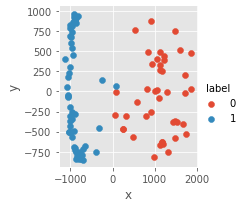

In [43]:
sns.FacetGrid(df, hue = "label").map(plt.scatter, "x", "y").add_legend()

<AxesSubplot:xlabel='x', ylabel='y'>

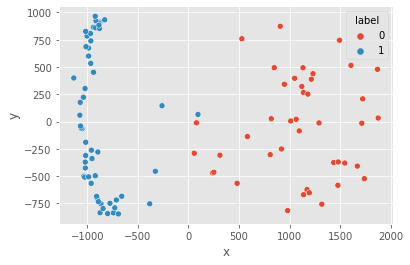

In [44]:
sns.scatterplot(data = df, x = "x", y = "y", hue = "label")

In [50]:
from ipywidgets import widgets

In [60]:
import plotly.graph_objects as go

import numpy as np
np.random.seed(1)

origin = widgets.Dropdown(
    options=list(df['label'].unique()),
    value=0,
    description="class",
)

f = go.FigureWidget([go.Scatter(x=x, y=y, mode='markers')])

scatter = f.data[0]
colors = ['#a3a7e4'] * len(x)
scatter.marker.color = colors
scatter.marker.size = [10] * len(x)
f.layout.hovermode = 'closest'

values = np.empty(len(x))

# create our callback function
def update_point(trace, points, selector):
    c = list(scatter.marker.color)
    s = list(scatter.marker.size)
    for i in points.point_inds:
        if origin.value == 0:
            c[i] = '#963484'
            s[i] = 20
            values[i] = origin.value
        else:
            c[i] = '#3066BE'
            s[i] = 20
            values[i] = origin.value
        with f.batch_update():
            scatter.marker.color = c
            scatter.marker.size = s

def response(change):
    return change

scatter.on_click(update_point)
origin.observe(response, names = "value")

widgets.VBox([origin, f])

#f

    'data': [{'marker': …

In [63]:
np.where(values == 1)

(array([56], dtype=int64),)

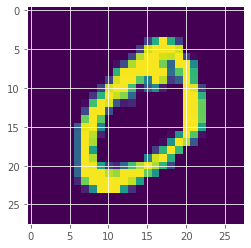

In [28]:
plt.imshow(x_train[0])